# Lesson 35: Pairs bootstrap

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l35_pairs_bootstrap.ipynb).*

<br /><br />

In [1]:
import numpy as np
import pandas as pd

import altair as alt

## Confidence intervals on regression parameters

In the last lesson, we computed the parameters that result in the best fit of a theoretical function to data. Now we turn to the problem of computing the confidence intervals of these parameters using **pairs bootstrap**. The idea is simple. We sample (*x*, *y*) data *in pairs* to get a bootstrap sample. We obtain a bootstrap replicate of the parameter values by performing the regression again on the bootstrap sample. We do this again and again to eventually get a confidence interval.

There are alternative methods, such as **wild bootstrap** and **residual bootstrap**, but we will use pairs bootstrap here.

## The data set

For this analysis, we will again turn to the Darwin finch data set. We consider the data *G. scandens* beak length and depth from 1987. Let's load and take a quick look at the data.

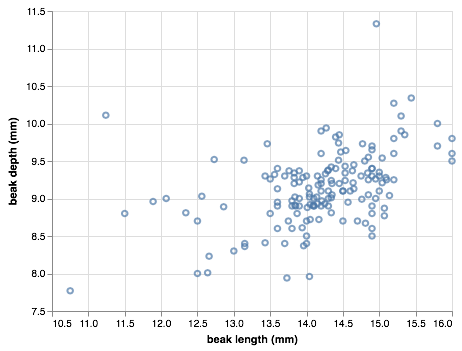

In [2]:
# Load data frame and only keep what we need
df = pd.read_csv('data/grant_complete.csv', comment='#')
df = df.loc[df['year']==1987, :]
df = df.drop_duplicates(subset=['band'])
df = df.loc[df['species']=='scandens', ['beak length (mm)', 'beak depth (mm)']]

# Make a plot
dots = alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('beak length (mm):Q', scale=alt.Scale(zero=False)),
        y=alt.Y('beak depth (mm):Q', scale=alt.Scale(zero=False)),
    )

dots

## Linear regression

Beak depth and beak length might be linearly related, so we can perform a linear regression. We can use `np.polyfit()` as a shortcut for doing linear regression. This data to a polynomial of any degree (including degree 1, which is for a linear regression). Let's get the slope and intercept from a linear regression of these data. Before we do that, we'll bust the beak length and depth data out of the data frame as Numpy arrays, since we'll need to do that for speed later when we do the bootstrapping.

In [3]:
# Pull out beak length and depth
beak_length = df['beak length (mm)'].values
beak_depth = df['beak depth (mm)'].values

# Do linear regression
slope, intercept = np.polyfit(beak_length, beak_depth, deg=1)

# Take a look
slope, intercept

(0.262258885049905, 5.416852701227372)

So, we have a slope of about 0.26 and an intercept of about 5.3 mm. We can plot the resulting regression line along with the data

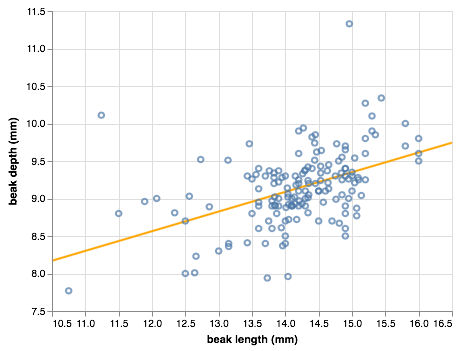

In [4]:
# Make data frame for regression line
x = np.array([10.5, 16.5])
y = slope * x + intercept
df_line = pd.DataFrame({'x': x, 'y': y})

# Make chart
reg_line = alt.Chart(df_line
    ).mark_line(
        size=3,
        color='orange'
    ).encode(
        x=alt.X('x:Q', title='beak length (mm)', scale=alt.Scale(zero=False)),
        y=alt.Y('y:Q', title='beak depth (mm)', scale=alt.Scale(zero=False)),
    )

reg_line + dots

## Pairs bootstrap

To perform pairs bootstrap for a linear regression, we will write a generic function to do it for any (*x*, *y*) data set. The trick is that we use `np.random.choice()` to choose *an index* of a pair of data points. With each resampled set of pairs of points, we compute a slope and an intercept.

In [5]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

Let's put this function to work and compute bootstrap replicates.

In [6]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(beak_length,
                                                        beak_depth,
                                                        size=10000)

Now that we have the replicates, we can compute the confidence intervals for the regression parameters.

In [7]:
print('slope conf int:', *np.percentile(bs_slope_reps, [2.5, 97.5]))
print('slope conf int:', *np.percentile(bs_intercept_reps, [2.5, 97.5]))

slope conf int: 0.1407971115793715 0.3786981644044019
slope conf int: 3.75497093333768 7.152876613015407


## Plotting the confidence interval

If we want to display on the plot how the regression line may change, we can do the following procedure.

1. Generate the fit line for each bootstrap replicate for many points along the *x*-axis.
2. For each *x*-value, compute the 2.5th and 97.5th percentile values of the *y*-values of the lines from teh bootstrap replicates.
3. These represent the 95% confidence interval for the regression line at each point *x*.

Let's do this procedure to make our plot. We will use some of Numpy's clever functions to generate the lines without looping.

In [8]:
# x-values
x = np.linspace(10.5, 16.5, 200)

# y-values of each point
y = np.outer(bs_slope_reps, x) + np.stack([bs_intercept_reps]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

Now that we have the upper and lower bounds for the confidence interval, we can make a plot of it.

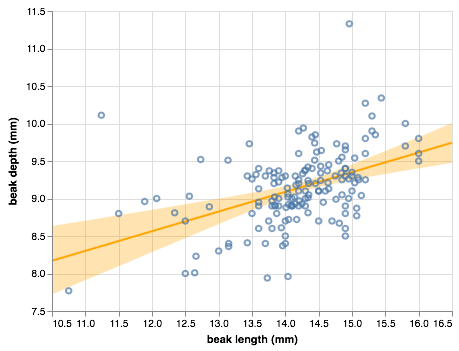

In [9]:
df_conf = pd.DataFrame({'x': x, 'high': high, 'low': low})

conf = alt.Chart(df_conf
    ).mark_area(
        color='orange',
        opacity=0.3
    ).encode(
        x=alt.X('x:Q', title='beak length (mm)', scale=alt.Scale(zero=False)),
        y=alt.Y('low:Q', title='beak depth (mm)', scale=alt.Scale(zero=False)),
        y2=alt.Y2('high:Q')
    )

conf + reg_line + dots

As expected, whatever regression line we got from bootstrapping should go through the heart of the data, and we are less sure about the extremities.

You can use this same procedure with nonlinear regression as well. To do so, you need to write a function that will take in some (*x*-*y*) data and do whatever regression you want to do and return the best fit parametres. Then you re-write the `pairs_bootstrap_linreg()` (obviously with a different name) where you sub in your new function for the `polyfit()` function.